In [128]:
import json
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from textstat.textstat import textstat

%matplotlib inline

### Loading data for selection

In [129]:
considered_samples = 10000
values_per_label = 1250

In [130]:
columns_full = ['title', 'keywords', 'readingTime', 'text']
columns = ['title', 'keywords', 'readingTime', 'text', 'num_images', 'num_tags', 'count_tag_fol', 
           'count_tag_posts', 'weekday', 'seconds', 'count_words', 'FK_grade']

def get_short_info(obj):
    return [obj['likes']]

def get_full_info(obj):
    res = []
    for col in columns_full:
        if col == 'keywords':
            res.append(' '.join(obj[col]))
        else:
            res.append(obj[col])
            
    res.append(len(obj['images']))
    res.append(len(obj['tags']))
    res.append(sum(list(map(lambda x: x['followerCount'], obj['tags']))))
    res.append(sum(list(map(lambda x: x['postCount'], obj['tags']))))
    
    date = datetime.datetime.fromtimestamp(float(obj['date']['$numberLong'])/1000.)
    res.append(date.weekday())
    res.append(date.hour*60*60 + date.minute*60 + date.second)
    res.append(len(obj['text'].split(' ')))
    if obj['text'] == '':
        res.append(0)
    else:
        res.append(textstat.flesch_kincaid_grade(obj['text']))
    
    return res

data = []
ind = []

for i, l in enumerate(open('data/medium.json')):
    obj = json.loads(l)
    ind.append(obj['id'])
    data.append(get_short_info(obj))
    if len(data) > considered_samples:
        break

In [131]:
df = pd.DataFrame(data, index=ind, columns=['likes'])

df['group'] = 0
borders = [1e-20, 2, 4, np.inf]

print(len(df[df.likes == 0]))

bins = [df[df.likes == 0].sample(values_per_label, replace=True)]
for i in range(1, len(borders)):
    ins = np.logical_and(np.log1p(df.likes) < borders[i], np.log1p(df.likes) >= borders[i-1])
    print(len(df[ins]))
    df.loc[ins, 'group'] = i
    bins.append(df[ins].sample(values_per_label, replace=True))
    
df = pd.concat(bins)

839
3401
2005
3756


In [132]:
ind = df.index
new_info = {}

count = 0
for i, l in enumerate(open('data/medium.json')):
    obj = json.loads(l)
    if i > considered_samples:
        break
    if i % 1000 == 0:
        print('.', end='')
    if obj['id'] in ind and obj['id'] not in new_info:
        new_info[obj['id']] = get_full_info(obj)

...........

In [133]:
new_df = pd.DataFrame.from_dict(new_info, orient='index')
new_df.columns = columns
df = pd.merge(df, new_df, 'inner', left_index=True, right_index=True)

df.head()

,likes,group,title,keywords,readingTime,text,num_images,num_tags,count_tag_fol,count_tag_posts,weekday,seconds,count_words,FK_grade
1029b4c4909a,0,0,Ain’t no crime…,Podcast Serial Reply All,3.621698,America knows how to knock out a proper crime ...,3,3,1070,12115,1,5164,791,11.1
103d43a0319c,18,2,"For Post-9/11 Veterans, the Best Thank You Is ...",Military Veterans Philanthropy,3.636164,Matt Richtel’s recent New York Times piece on ...,2,3,967,8957,1,75231,810,9.9
103d43a0319c,18,2,"For Post-9/11 Veterans, the Best Thank You Is ...",Military Veterans Philanthropy,3.636164,Matt Richtel’s recent New York Times piece on ...,2,3,967,8957,1,75231,810,9.9
10492495c715,7120,3,There is something extraordinary happening in ...,Entrepreneurship Sharing Economy Social Media ...,5.162264,Most of us haven’t quite realized there is som...,1,3,631922,95507,2,12751,1217,6.2
1053559b1e42,1,1,Kirkpatrick to McCain: forget about ‘the conse...,Donald Trump Politics Arizona,0.260377,After the bombshell from The Washington Post e...,0,3,535679,143961,5,21141,47,20.4


### Prepare text features

In [134]:
import re
from nltk.tokenize import RegexpTokenizer
from collections import Counter,defaultdict

tokenizer = RegexpTokenizer(r"\w+", flags=re.UNICODE)
token_counts = Counter()
all_texts = np.hstack([df.text.values,df.title.values,df.keywords])

for i, s in enumerate(all_texts):
    if type(s) is not str:
        continue
    if i % 1000 == 0:
        print('.', end='')
    token_counts.update(tokenizer.tokenize(s.lower()))

...............

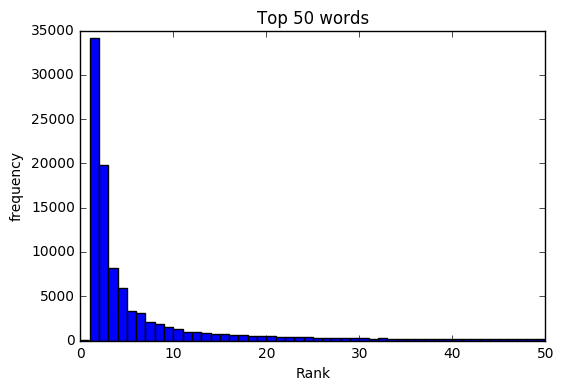

In [135]:
plt.hist(list(token_counts.values()),range=[0,50],bins=50);
plt.title('Top 50 words')
plt.xlabel('Rank')
plt.ylabel('frequency')

In [136]:
min_count = 10
tokens = [t for t in token_counts if token_counts[t] >= min_count]

In [137]:
token_to_id = {t:i+1 for i,t in enumerate(tokens)}
null_token = "NULL"
token_to_id[null_token] = 0
print("Tokens:",len(token_to_id))

Tokens: 22162


### Cutting text

Max length:
* title: 15 words;
* text: 1200 words;
* keywords: 10 words.

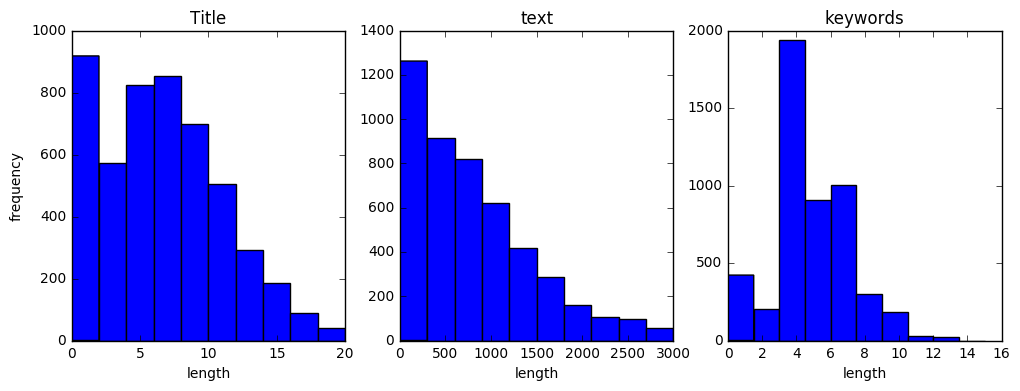

In [138]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title('Title')
plt.hist([len(tokenizer.tokenize(s.lower())) for s in df.title.values], range=(0,20))
plt.xlabel("length")
plt.ylabel('frequency')
plt.subplot(1,3,2)
plt.title('text')
plt.hist([len(tokenizer.tokenize(s.lower())) for s in df.text.values], range=(0,3000))
plt.xlabel("length")
plt.subplot(1,3,3)
plt.title('keywords')
plt.xlabel("length")
plt.hist([len(tokenizer.tokenize(s.lower())) for s in df.keywords.values], range=(0,15));

In [139]:
def vectorize(strings, token_to_id, max_len=1000):
    token_matrix = []
    for s in strings:
        if type(s) is not str:
            token_matrix.append([0]*max_len)
            continue
        s = s.lower()
        tokens = tokenizer.tokenize(s)
        token_ids = list(map(lambda token: token_to_id.get(token,0), tokens))[:max_len]
        token_ids += [0]*(max_len - len(token_ids))
        token_matrix.append(token_ids)

    return np.array(token_matrix)

### Train/test splitting

In [140]:
text_tokens = vectorize(df.text.values,token_to_id,max_len = 1200)
print('Text OK')
title_tokens = vectorize(df.title.values,token_to_id,max_len = 15)
print('Title OK')
keywords_tokens = vectorize(df.keywords,token_to_id,max_len = 10)
print('Keywords OK')


Text OK
Title OK
Keywords OK


In [141]:
indexes = df.index.values
target = df.group.values.astype('int8')

title_tokens = title_tokens.astype('int32')
text_tokens = text_tokens.astype('int32')
keywords_tokens = keywords_tokens.astype('int32')

num_cols = ['readingTime', 'num_images', 'num_tags', 'count_tag_fol', 'count_tag_posts', 'weekday', 'seconds', 'count_words']
df_non_text = df[num_cols].values.astype('float32')

In [142]:
from sklearn.model_selection import train_test_split
data_tuple = train_test_split(indexes,title_tokens,text_tokens,keywords_tokens,df_non_text,target)

ind_tr,ind_ts,title_tr,title_ts,text_tr,text_ts,keyw_tr,keyw_ts,nontext_tr,nontext_ts,target_tr,target_ts = data_tuple

### Save (load) progress

In [143]:
import pickle

# Save

with open("preprocessed_data_small.pcl",'wb') as fout:
    pickle.dump(data_tuple,fout)
with open("token_to_id_small.pcl",'wb') as fout:
    pickle.dump(token_to_id,fout)

# Load

# with open("preprocessed_data.pcl",'rb') as fin:
#     data_tuple = pickle.load(fin)
# ind_tr,ind_ts,title_tr,title_ts,text_tr,text_ts,keyw_tr,keyw_ts,nontext_tr,nontext_ts,target_tr,target_ts = data_tuple
# with open("token_to_id.pcl",'rb') as fin:
#     token_to_id = pickle.load(fin)

In [206]:
###############################################
## If you want to append some extra features ##
##      there is the best place for them     ##
###############################################

### NN Stuff

In [144]:
import lasagne
from theano import tensor as T
import theano

title_token_ids = T.matrix("title_token_ids",dtype='int32')
text_token_ids = T.matrix("text_token_ids",dtype='int32')
keyw_token_ids = T.matrix("keyw_token_ids",dtype='int32')
non_text = T.matrix("non_text",dtype='float32')
target_y = T.ivector("group")

In [145]:
###########
## Input ##
###########

title_inp = lasagne.layers.InputLayer((None,title_tr.shape[1]),input_var=title_token_ids)
text_inp = lasagne.layers.InputLayer((None,text_tr.shape[1]),input_var=text_token_ids)
keyw_inp = lasagne.layers.InputLayer((None,keyw_tr.shape[1]),input_var=keyw_token_ids)
cat_inp = lasagne.layers.InputLayer((None,df_non_text.shape[1]), input_var=non_text)

####################
## Parallel Convs ##
####################

text_nn = lasagne.layers.EmbeddingLayer(text_inp,input_size=len(token_to_id)+1,output_size=128)
text_nn = lasagne.layers.DimshuffleLayer(text_nn, [0,2,1])
text_nn = lasagne.layers.Conv1DLayer(text_nn,num_filters=128,filter_size=3)
text_nn = lasagne.layers.GlobalPoolLayer(text_nn)

title_nn = lasagne.layers.EmbeddingLayer(title_inp, input_size=len(token_to_id)+1, output_size=128)
title_nn = lasagne.layers.DimshuffleLayer(title_nn, [0,2,1])
title_nn = lasagne.layers.Conv1DLayer(title_nn, num_filters=128, filter_size=3)
title_nn = lasagne.layers.GlobalPoolLayer(title_nn)

keyw_nn = lasagne.layers.EmbeddingLayer(keyw_inp, input_size=len(token_to_id)+1, output_size=128)
keyw_nn = lasagne.layers.DimshuffleLayer(keyw_nn, [0,2,1])
keyw_nn = lasagne.layers.Conv1DLayer(keyw_nn, num_filters=128, filter_size=3)
keyw_nn = lasagne.layers.GlobalPoolLayer(keyw_nn)

cat_nn = lasagne.layers.DenseLayer(cat_inp, 128)

########################
## Merging and Output ##
########################

nn = lasagne.layers.concat([text_nn, title_nn, keyw_nn, cat_nn])                               
nn = lasagne.layers.DenseLayer(nn,1024, nonlinearity=lasagne.nonlinearities.sigmoid)
nn = lasagne.layers.DropoutLayer(nn,p=0.05)
nn = lasagne.layers.DenseLayer(nn,4,nonlinearity=lasagne.nonlinearities.softmax)

In [146]:
weights = lasagne.layers.get_all_params(nn,trainable=True)
prediction = lasagne.layers.get_output(nn)

loss = lasagne.objectives.multiclass_hinge_loss(prediction, target_y).mean()
updates = lasagne.updates.adam(loss, weights)

det_prediction = lasagne.layers.get_output(nn,deterministic=True)
det_loss = lasagne.objectives.multiclass_hinge_loss(det_prediction, target_y).mean()

In [147]:
train_fun = theano.function([text_token_ids,title_token_ids,keyw_token_ids,non_text,target_y],[loss,prediction],updates = updates)
eval_fun = theano.function([text_token_ids,title_token_ids,keyw_token_ids,non_text,target_y],[det_loss,det_prediction])

### Minibatch training

In [148]:
def iterate_minibatches(*arrays,**kwargs):
    
    batchsize=kwargs.get("batchsize",100)
    shuffle = kwargs.get("shuffle",True)
    
    if shuffle:
        indices = np.arange(len(arrays[0]))
        np.random.shuffle(indices)
    for start_idx in range(0, len(arrays[0]) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield [arr[excerpt] for arr in arrays]

In [151]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc

n_epochs = 100
batch_size = 100
minibatches_per_epoch = 50

def pr_auc(y_true, y_pred):
    pr, rec, _ = precision_recall_curve(y_true, y_pred)
    return '%.3f' % auc(rec, pr)

for i in range(n_epochs):
    
    #training
    epoch_y_true = []
    epoch_y_pred = []
    
    b_c = b_loss = 0
    for j, (b_text,b_title,b_keyw, b_cat, b_y) in enumerate(
        iterate_minibatches(text_tr,title_tr,keyw_tr,nontext_tr,target_tr,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch:break

        loss,value = train_fun(b_text,b_title,b_keyw,b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(value)
        print('.',end='')

    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print("\nTrain:")
    print('\tAverage loss:', b_loss/b_c)
    print('\tAUC:', ['%.3f' % roc_auc_score(epoch_y_true == i, epoch_y_pred[:,i]) for i in range(4)])
    print('\tPR AUC:',[pr_auc(epoch_y_true == i, epoch_y_pred[:,i]) for i in range(4)])
    
    
    #evaluation
    epoch_y_true = []
    epoch_y_pred = []
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_keyw,b_cat, b_y) in enumerate(
        iterate_minibatches(text_ts,title_ts,keyw_ts,nontext_ts,target_ts,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch: break
        loss,value = eval_fun(b_desc,b_title,b_keyw,b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(value)

    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print("Val:")
    print('\tAverage loss:', b_loss/b_c)
    print('\tAUC:', ['%.3f' % roc_auc_score(epoch_y_true == i, epoch_y_pred[:,i]) for i in range(4)])
    print('\tPR AUC:',[pr_auc(epoch_y_true == i, epoch_y_pred[:,i]) for i in range(4)])

.....................................
Train:
	Average loss: 1.05575221959
	AUC: ['0.604', '0.503', '0.512', '0.553']
	PR AUC: ['0.327', '0.250', '0.266', '0.272']
Val:
	Average loss: 1.0233157814
	AUC: ['0.625', '0.517', '0.496', '0.620']
	PR AUC: ['0.378', '0.271', '0.237', '0.291']
.....................................
Train:
	Average loss: 1.05308888964
	AUC: ['0.604', '0.517', '0.512', '0.552']
	PR AUC: ['0.331', '0.262', '0.263', '0.279']
Val:
	Average loss: 1.02923792065
	AUC: ['0.631', '0.517', '0.501', '0.409']
	PR AUC: ['0.382', '0.254', '0.229', '0.219']
.......

KeyboardInterrupt: 

In [152]:
from sklearn.metrics import confusion_matrix, roc_curve

epoch_y_true = []
epoch_y_pred = []
b_c = b_loss = 0
for j, (b_desc,b_title,b_keyw,b_cat, b_y) in enumerate(
    iterate_minibatches(text_ts,title_ts,keyw_ts,nontext_ts,target_ts,batchsize=batch_size//2,shuffle=True)):
    loss,value = eval_fun(b_desc,b_title,b_keyw,b_cat,b_y)

    b_loss += loss
    b_c +=1

    epoch_y_true.append(b_y)
    epoch_y_pred.append(value)
    print(end='.')


epoch_y_true = np.concatenate(epoch_y_true)
epoch_y_pred = np.concatenate(epoch_y_pred)

print('\nConfusion matrix')
cm = confusion_matrix(epoch_y_true, np.argmax(epoch_y_pred, axis=1))
print(cm)#/cm.sum(axis=1).reshape(-1,1))
print('AUC:', ['%.3f' % roc_auc_score(epoch_y_true == i, epoch_y_pred[:,i]) for i in range(4)])
print('PR AUC:',[pr_auc(epoch_y_true == i, epoch_y_pred[:,i]) for i in range(4)])

.........................
Confusion matrix
[[264  14  39  12]
 [243  44  18   9]
 [228  27  24  14]
 [259  31  16   8]]
AUC: ['0.622', '0.547', '0.520', '0.599']
PR AUC: ['0.370', '0.277', '0.236', '0.286']


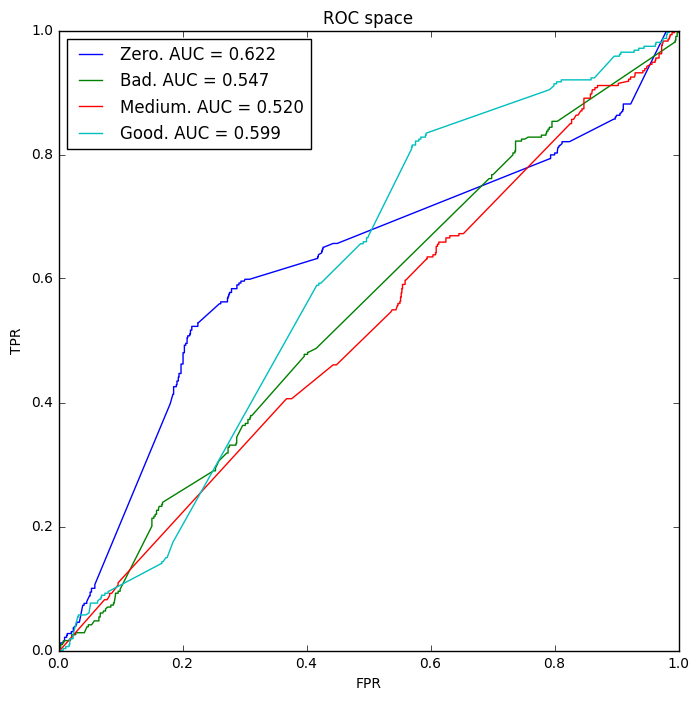

In [153]:
classes = ['Zero', 'Bad', 'Medium', 'Good']
plt.figure(figsize=(8,8))
for i in range(4):
    fpr, tpr, _ = roc_curve(epoch_y_true == i, epoch_y_pred[:,i])
    plt.plot(fpr, tpr, label = classes[i] + '. AUC = %.3f' % roc_auc_score(epoch_y_true == i, epoch_y_pred[:,i]))
plt.legend(loc='best')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC space');